#**FUNCTION-1**

In [2]:
import numpy as np
import pandas as pd
import joblib
import os
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import random
from sklearn.preprocessing import StandardScaler

#Final.ipynb file should contain the following :

#It should have two functions.
###Function-1
######Should include entire pipeline, from data preprocessing to making final predictions.
###3It should take in raw data as input.
###It should return predictions for your input. Here the input can be a single point or a set of points.
##def final_fun_1(X):
#.....
#.....
#..... # you will use the best model that you found out with your experiments
#return predictions made on X ( Raw Data)

#Load the raw test data


In [26]:
# Load the raw train data
Test_Provider = pd.read_csv("/content/Validation_Provider.csv")
Test_beneficiary_data = pd.read_csv("/content/Validation_Beneficiary.csv")
Test_inpatient_data = pd.read_csv("/content/Validation_Inpatient.csv")
Test_outpatient_data = pd.read_csv("/content/Validation_Outpatient.csv")

In [27]:
def create_feature_using_groupby(Test_df, gruopby_col, operation_col,operation):
    '''
    This function groupby the 'Train_df' and 'Test_df' dataframe by 'gruopby_col' and performs 'operation' on 'operation_col'
    '''
    
    for col in operation_col:
        # create new column name for the dataframe
        new_col_name = 'Per'+''.join(gruopby_col)+'_'+operation+'_'+col
        #print(new_col_name)
        Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
    return Test_df

# **ALL THE STEPS THAT WE ARE DOING BELOW ARE WE HAVE PERFORMED DURING EDA AND FEATURE ENGINEERING SO SAME STEPS WE ARE PERFORMING HERE FOR PREPROCESS NEW DATA FOR FINAL DATA PIPELINE**

In [110]:
# define a function to preprocess raw test data
def preprocess_test_data(Test_Provider, Test_beneficiary_data, Test_inpatient_data, Test_outpatient_data):
    
    # Replacing 2 with 0 for chronic conditions, Zero indicates chronic condition is No
    Test_beneficiary_data = Test_beneficiary_data.replace ({'ChronicCond_Alzheimer' :2 ,'ChronicCond_Heartfailure':2 ,'ChronicCond_KidneyDisease':2 ,'ChronicCond_Cancer':2,
                                                    'ChronicCond_ObstrPulmonary': 2 , 'ChronicCond_Depression':2 , 'ChronicCond_Diabetes':2 , 'ChronicCond_IschemicHeart':2,
                                                    'ChronicCond_Osteoporasis':2 , 'ChronicCond_rheumatoidarthritis':2 , 'ChronicCond_stroke': 2 },0)



    # convert all these columns datatypes to numeric
    Test_beneficiary_data[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]] = Test_beneficiary_data[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]].apply(pd.to_numeric)

    # calculate patient risk score by summing up all risk scores
    Test_beneficiary_data['patient_risk_score'] =   Test_beneficiary_data['ChronicCond_Alzheimer'] + Test_beneficiary_data['ChronicCond_Heartfailure']\
                                              + Test_beneficiary_data['ChronicCond_KidneyDisease'] + Test_beneficiary_data['ChronicCond_Cancer'] \
                                              + Test_beneficiary_data['ChronicCond_ObstrPulmonary'] + Test_beneficiary_data['ChronicCond_Depression'] \
                                              + Test_beneficiary_data['ChronicCond_Diabetes'] + Test_beneficiary_data['ChronicCond_IschemicHeart'] \
                                              + Test_beneficiary_data['ChronicCond_Osteoporasis'] + Test_beneficiary_data['ChronicCond_rheumatoidarthritis'] \
                                              + Test_beneficiary_data['ChronicCond_stroke'] + Test_beneficiary_data['RenalDiseaseIndicator']

    # Replacing '2' with '0' for Gender Type
    Test_beneficiary_data['DOB'] = pd.to_datetime(Test_beneficiary_data['DOB'])
    Test_beneficiary_data['DOD'] = pd.to_datetime(Test_beneficiary_data['DOD'])

#Calculate max value of date_of_death
    max_date_of_death = Test_beneficiary_data['DOD'].max()

#Handle missing values in date_of_death
    Test_beneficiary_data['DOD'].fillna(max_date_of_death, inplace=True)

    # Get the birth month and Birth year for DOB and DOD
    Test_beneficiary_data['Birth_Year'] = Test_beneficiary_data['DOB'].dt.year
    Test_beneficiary_data['Birth_Month'] = Test_beneficiary_data['DOB'].dt.month

# Subtract date of birth from date of death
    Test_beneficiary_data['age_days'] = Test_beneficiary_data['DOD'] - Test_beneficiary_data['DOB']

# Divide the difference in days by 365.25 to get the difference in years
    Test_beneficiary_data['age_years'] = Test_beneficiary_data['age_days'] / pd.Timedelta(days=365.25)

# Create a new column age
    Test_beneficiary_data['age'] = Test_beneficiary_data['age_years'].apply(lambda x: round(x,2))
    # Set value=1 if the patient is dead i.e DOD value is not null







    # convert ClaimStartDt, ClaimEndDt from string to datetime format
    Test_inpatient_data['ClaimStartDt'] = pd.to_datetime(Test_inpatient_data['ClaimStartDt'] , format = '%Y-%m-%d')
    Test_inpatient_data['ClaimEndDt'] = pd.to_datetime(Test_inpatient_data['ClaimEndDt'],format = '%Y-%m-%d')

    # convert AdmissionDt, DischargeDt from string to datetime format
    Test_inpatient_data['AdmissionDt'] = pd.to_datetime(Test_inpatient_data['AdmissionDt'] , format = '%Y-%m-%d')
    Test_inpatient_data['DischargeDt'] = pd.to_datetime(Test_inpatient_data['DischargeDt'],format = '%Y-%m-%d')

    # Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
    Test_inpatient_data['Hospitalization_Duration'] = ((Test_inpatient_data['DischargeDt'] - Test_inpatient_data['AdmissionDt']).dt.days)+1
    Test_inpatient_data['Claim_Period'] = ((Test_inpatient_data['ClaimEndDt'] - Test_inpatient_data['ClaimStartDt']).dt.days)+1

    # ExtraClaimDays = Claim_Period - Hospitalization_Duration
    Test_inpatient_data['ClaimStart_Year'] = Test_inpatient_data['ClaimStartDt'].dt.year
    Test_inpatient_data['ClaimStart_Month'] = Test_inpatient_data['ClaimStartDt'].dt.month


    # Get the months and year of claim start and claim end
    Test_inpatient_data['ClaimEnd_Year'] = Test_inpatient_data['ClaimEndDt'].dt.year
    Test_inpatient_data['ClaimEnd_Month'] = Test_inpatient_data['ClaimEndDt'].dt.month

    # Get the month and year of Admission_Year and Admission_Month
    Test_inpatient_data['Admission_Year'] = Test_inpatient_data['AdmissionDt'].dt.year
    Test_inpatient_data['Admission_Month'] = Test_inpatient_data['AdmissionDt'].dt.month

    Test_inpatient_data['Discharge_Year'] = Test_inpatient_data['DischargeDt'].dt.year
    Test_inpatient_data['Discharge_Month'] = Test_inpatient_data['DischargeDt'].dt.month


    ClmDiagnosisCode_IP_df = pd.DataFrame(columns = ['DiagnosisCode'])
    ClmDiagnosisCode_IP_df['DiagnosisCode'] = pd.concat([Test_inpatient_data["ClmDiagnosisCode_1"], 
                                           Test_inpatient_data["ClmDiagnosisCode_2"], 
                                           Test_inpatient_data["ClmDiagnosisCode_3"], 
                                           Test_inpatient_data["ClmDiagnosisCode_4"],
                                           Test_inpatient_data["ClmDiagnosisCode_5"], 
                                           Test_inpatient_data["ClmDiagnosisCode_6"],
                                           Test_inpatient_data["ClmDiagnosisCode_7"],
                                           Test_inpatient_data["ClmDiagnosisCode_8"],
                                           Test_inpatient_data["ClmDiagnosisCode_9"],
                                           Test_inpatient_data["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()



     # Concat all the claim precedurecodes in a single dataframe
    ClmProcedureCode_IP_df = pd.DataFrame(columns = ['ProcedureCode'])
    ClmProcedureCode_IP_df['ProcedureCode'] = pd.concat([Test_inpatient_data["ClmProcedureCode_1"], 
                                   Test_inpatient_data["ClmProcedureCode_2"],
                                   Test_inpatient_data["ClmProcedureCode_3"],
                                   Test_inpatient_data["ClmProcedureCode_4"], 
                                   Test_inpatient_data["ClmProcedureCode_5"], 
                                   Test_inpatient_data["ClmProcedureCode_6"]], axis=0, sort=True).dropna()







    # convert ClaimStartDt, ClaimEndDt from string to datetime format
    # convert ClaimStartDt, ClaimEndDt from string to datetime format
    Test_outpatient_data['ClaimStartDt'] = pd.to_datetime(Test_outpatient_data['ClaimStartDt'] , format = '%Y-%m-%d')
    Test_outpatient_data['ClaimEndDt'] = pd.to_datetime(Test_outpatient_data['ClaimEndDt'],format = '%Y-%m-%d')

# Get the months and year of claim start and claim end
    Test_outpatient_data['ClaimStart_Year'] = Test_outpatient_data['ClaimStartDt'].dt.year
    Test_outpatient_data['ClaimStart_Month'] = Test_outpatient_data['ClaimStartDt'].dt.month

# Calculate Claim_Period = ClaimEndDt - ClaimStartDt
    Test_outpatient_data['ClaimEnd_Year'] = Test_outpatient_data['ClaimEndDt'].dt.year
    Test_outpatient_data['ClaimEnd_Month'] = Test_outpatient_data['ClaimEndDt'].dt.month

    Test_outpatient_data['Claim_Period'] = ((Test_outpatient_data['ClaimEndDt'] - Test_outpatient_data['ClaimStartDt']).dt.days)+1

    ClmDiagnosisCode_df_outpatient = pd.DataFrame(columns = ['DiagnosisCode'])

    ClmDiagnosisCode_df_outpatient['DiagnosisCode'] = pd.concat([Test_outpatient_data["ClmDiagnosisCode_1"], 
                                           Test_outpatient_data["ClmDiagnosisCode_2"], 
                                           Test_outpatient_data["ClmDiagnosisCode_3"], 
                                           Test_outpatient_data["ClmDiagnosisCode_4"],
                                           Test_outpatient_data["ClmDiagnosisCode_5"], 
                                           Test_outpatient_data["ClmDiagnosisCode_6"],
                                           Test_outpatient_data["ClmDiagnosisCode_7"],
                                           Test_outpatient_data["ClmDiagnosisCode_8"],
                                           Test_outpatient_data["ClmDiagnosisCode_9"],
                                           Test_outpatient_data["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna() 
    

    # Concat all the claim precedurecodes in a single dataframe
    ClmProcedureCode_OP_df = pd.DataFrame(columns = ['ProcedureCode'])
    ClmProcedureCode_OP_df['ProcedureCode'] = pd.concat([Test_outpatient_data["ClmProcedureCode_1"], 
                                   Test_outpatient_data["ClmProcedureCode_2"],
                                   Test_outpatient_data["ClmProcedureCode_3"],
                                   Test_outpatient_data["ClmProcedureCode_4"], 
                                   Test_outpatient_data["ClmProcedureCode_5"], 
                                   Test_outpatient_data["ClmProcedureCode_6"]], axis=0, sort=True).dropna()



    # Create a new column Inpatient_or_Outpatient where Inpatient =1 and Outpatient = 0
# Create a new column Inpatient_or_Outpatient where Inpatient =1 and Outpatient = 0
    Test_inpatient_data['Inpatient_or_Outpatient'] = 1
    Test_outpatient_data['Inpatient_or_Outpatient'] = 0


    # Merge inpatient and outpatient dataframes based on common columns
    common_columns_test = [ idx for idx in Test_outpatient_data.columns if idx in Test_inpatient_data.columns]
    Inpatient_Outpatient_Merge_Test = pd.merge(Test_inpatient_data, Test_outpatient_data, left_on = common_columns_test, right_on = common_columns_test,how = 'outer')

# Merge beneficiary details with inpatient and outpatient data
    Inpatient_Outpatient_Beneficiary_Merge_Test = pd.merge(Inpatient_Outpatient_Merge_Test, Test_beneficiary_data,
                                                  left_on='BeneID',right_on='BeneID',how='inner')

    Final_Dataset_Test = pd.merge(Inpatient_Outpatient_Beneficiary_Merge_Test, Test_Provider , how = 'inner', on = 'Provider' )


    ClmDiagnosisCode_df_outpatient_test = pd.DataFrame(columns = ['DiagnosisCode'])

    ClmDiagnosisCode_df_outpatient_test['DiagnosisCode'] = pd.concat([Final_Dataset_Test["ClmDiagnosisCode_1"], 
                                           Final_Dataset_Test["ClmDiagnosisCode_2"], 
                                           Final_Dataset_Test["ClmDiagnosisCode_3"], 
                                           Final_Dataset_Test["ClmDiagnosisCode_4"],
                                           Final_Dataset_Test["ClmDiagnosisCode_5"], 
                                           Final_Dataset_Test["ClmDiagnosisCode_6"],
                                           Final_Dataset_Test["ClmDiagnosisCode_7"],
                                           Final_Dataset_Test["ClmDiagnosisCode_8"],
                                           Final_Dataset_Test["ClmDiagnosisCode_9"],
                                           Final_Dataset_Test["ClmDiagnosisCode_10"]], axis=0, sort=True).dropna()

    # Concat all the claim precedurecodes in a single dataframe
    ClmProcedureCode_IP_df_test = pd.DataFrame(columns = ['ProcedureCode'])
    ClmProcedureCode_IP_df_test['ProcedureCode'] = pd.concat([Final_Dataset_Test["ClmProcedureCode_1"], 
                                   Final_Dataset_Test["ClmProcedureCode_2"],
                                   Final_Dataset_Test["ClmProcedureCode_3"],
                                   Final_Dataset_Test["ClmProcedureCode_4"], 
                                   Final_Dataset_Test["ClmProcedureCode_5"], 
                                   Final_Dataset_Test["ClmProcedureCode_6"]], axis=0, sort=True).dropna()

     
    Final_Dataset_Test['patient_risk_score'] =  Final_Dataset_Test['ChronicCond_Alzheimer'] + Final_Dataset_Test['ChronicCond_Heartfailure']\
                                              + Final_Dataset_Test['ChronicCond_KidneyDisease'] + Final_Dataset_Test['ChronicCond_Cancer'] \
                                              + Final_Dataset_Test['ChronicCond_ObstrPulmonary'] + Final_Dataset_Test['ChronicCond_Depression'] \
                                              + Final_Dataset_Test['ChronicCond_Diabetes'] + Final_Dataset_Test['ChronicCond_IschemicHeart'] \
                                              + Final_Dataset_Test['ChronicCond_Osteoporasis'] + Final_Dataset_Test['ChronicCond_rheumatoidarthritis'] \
                                              + Final_Dataset_Test['ChronicCond_stroke'] + Final_Dataset_Test['RenalDiseaseIndicator']                              
      # Convert columns to datetime
    Final_Dataset_Test['DOB'] = pd.to_datetime(Final_Dataset_Test['DOB'])
    Final_Dataset_Test['DOD'] = pd.to_datetime(Final_Dataset_Test['DOD'])

#Calculate max value of date_of_death
    max_date_of_death = Final_Dataset_Test['DOD'].max()

#Handle missing values in date_of_death
    Final_Dataset_Test['DOD'].fillna(max_date_of_death, inplace=True)

# Subtract date of birth from date of death
    Final_Dataset_Test['age_days'] = Final_Dataset_Test['DOD'] - Final_Dataset_Test['DOB']

# Divide the difference in days by 365.25 to get the difference in years
    Final_Dataset_Test['age_years'] = Final_Dataset_Test['age_days'] / pd.Timedelta(days=365.25)

# Create a new column age
    Final_Dataset_Test['patient_age'] = Final_Dataset_Test['age_years'].apply(lambda x: round(x,2))




    # create new feature total reimbursement amount for inpatient and outpatient
    Final_Dataset_Test['IP_OP_AnnualReimbursementAmt'] = Final_Dataset_Test['IPAnnualReimbursementAmt'] + Final_Dataset_Test['OPAnnualReimbursementAmt']
    Final_Dataset_Test['IP_OP_AnnualDeductibleAmt'] = Final_Dataset_Test['IPAnnualDeductibleAmt'] + Final_Dataset_Test['IPAnnualDeductibleAmt']

    # Fill missing results using 0
    columns_with_missing_values = Final_Dataset_Test.columns[Final_Dataset_Test.isna().any()].tolist()


    Final_Dataset_Test[['AdmissionDt', 'DischargeDt']] = Final_Dataset_Test[['AdmissionDt', 'DischargeDt']].where(Final_Dataset_Test[['AdmissionDt', 'DischargeDt']].notna(), 0)
    Final_Dataset_Test = Final_Dataset_Test.replace(np.nan, 0)

    
    # group by columns to create feature
    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_1'], columns, 'mean')

    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_2'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_3'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_4'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_5'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_6'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_1'], columns, 'mean')

    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_2'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']

    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_3'], columns, 'mean')

    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_4'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_5'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_6'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['BeneID'], columns, 'mean')

    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['AttendingPhysician'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['OperatingPhysician'], columns, 'mean')

    columns =['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['OtherPhysician'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['DiagnosisGroupCode'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
           'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'patient_age', 'Hospitalization_Duration', 'Claim_Period', 'patient_risk_score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmAdmitDiagnosisCode'], columns, 'mean')

    
    # Count the claims per provider
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['Provider'], ['ClaimID'], 'count')

    columns = ['ClaimID']
    grp_by_cols = ['BeneID', 'AttendingPhysician', 'OtherPhysician', 'OperatingPhysician', 'ClmAdmitDiagnosisCode', 'ClmProcedureCode_1',
                   'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
                   'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'DiagnosisGroupCode']
    for ele in grp_by_cols:
        lst = ['Provider', ele]
        Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, lst, columns, 'count')

    # remove the columns which are not required
    remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                    'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                    'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt','ClaimStart_Year', 'ClaimStart_Year', 'ClaimStart_Month',
                    'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month', 'Discharge_Year', 
                    'DischargeDt', 'DiagnosisGroupCode','age_days']


    Final_Dataset_Test_after_feature_engineering   =Final_Dataset_Test.drop(columns=remove_columns, axis=1)

    Final_Dataset_Test_after_feature_engineering=pd.get_dummies(Final_Dataset_Test_after_feature_engineering,columns=['Gender','Race'])



    if "PotentialFraud" in list(Test_Provider.columns):
        Final_Dataset_Provider_Test = Final_Dataset_Test_after_feature_engineering.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
        Final_Dataset_Provider_Test.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
        Final_Dataset_Provider_Test.PotentialFraud=Final_Dataset_Provider_Test.PotentialFraud.astype('int64')
        return Final_Dataset_Provider_Test
    else:
        Final_Dataset_Provider_Test  = Final_Dataset_Test_after_feature_engineering.groupby(['Provider'],as_index=False).agg('sum')
        return Final_Dataset_Provider_Test

# loading the raw data 

In [29]:
# Load the raw train data
Test_Provider = pd.read_csv("/content/Validation_Provider.csv")
Test_beneficiary_data = pd.read_csv("/content/Validation_Beneficiary.csv")
Test_inpatient_data = pd.read_csv("/content/Validation_Inpatient.csv")
Test_outpatient_data = pd.read_csv("/content/Validation_Outpatient.csv")
# drop PotentialFraud column for final_fun_1
Test_Provider_1 = Test_Provider.drop("PotentialFraud", axis=1)


In [30]:
# create a dictionary which will contain all the files
X = {"Test_Provider_1":Test_Provider_1, "Test_beneficiary_data":Test_beneficiary_data, "Test_inpatient_data":Test_inpatient_data, "Test_outpatient_data":Test_outpatient_data}


In [31]:
def final_fun_1(X):
    # Load the raw test data
    Test_Provider_1 = X['Test_Provider_1']
    Test_beneficiary_data = X['Test_beneficiary_data']
    Test_inpatient_data = X['Test_inpatient_data']
    Test_outpatient_data = X['Test_outpatient_data']
    
    # preprocess the test data
    Final_Dataset_Provider_Test = preprocess_test_data(Test_Provider_1, Test_beneficiary_data, Test_inpatient_data, Test_outpatient_data)
    
    # drop the 'Provider' column
    x_test_provider = Final_Dataset_Provider_Test[['Provider']]
    x_test = Final_Dataset_Provider_Test.drop(columns=['Provider'])
    
    # standardize the data
    standard_scaler = StandardScaler()
    x_test = standard_scaler.fit_transform(x_test)

    # load the trained voting classifier
    voting_clf = joblib.load('/content/ensemble_model.pkl')
    
    # make predictions using the voting classifier
    y_test_prediction = voting_clf.predict(x_test)
    
    # add the predictions to the 'predicted_label' column of the test data
    x_test_provider['predicted_label'] = y_test_prediction
    
    return x_test_provider


In [33]:
# call final_fun_1 for preprocessing, prediction
x_test_provider = final_fun_1(X)


<ipython-input-27-141cf41b21d4>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
<ipython-input-31-25ae5145a4d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_provider['predicted_label'] = y_test_prediction


In [34]:
# print predicted labels
x_test_provider.head(20)

,Provider,predicted_label
0,PRV51005,1
1,PRV51008,0
2,PRV51011,0
3,PRV51012,0
4,PRV51016,0
5,PRV51017,1
6,PRV51029,0
7,PRV51041,0
8,PRV51054,0
9,PRV51059,0


#Function-2
#Function-2

##Should include entire pipeline, from data preprocessing to making final predictions.
##It should take in raw data as input along with its target values.
##It should return the metric value that you are judging your models on.
#def final_fun_2(X,Y):

In [103]:
# Load the raw train data
Test_Provider = pd.read_csv("/content/Validation_Provider.csv")
Test_beneficiary_data = pd.read_csv("/content/Validation_Beneficiary.csv")
Test_inpatient_data = pd.read_csv("/content/Validation_Inpatient.csv")
Test_outpatient_data = pd.read_csv("/content/Validation_Outpatient.csv")

In [104]:
# create a dictionary which will contain all the files
X = {"Test_Provider":Test_Provider, "Test_beneficiary_data":Test_beneficiary_data, "Test_inpatient_data":Test_inpatient_data, "Test_outpatient_data":Test_outpatient_data}

In [133]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve

def final_fun_2(X):
    # Load the raw test data
    Test_Provider = X['Test_Provider']
    Test_beneficiary_data = X['Test_beneficiary_data']
    Test_inpatient_data = X['Test_inpatient_data']
    Test_outpatient_data = X['Test_outpatient_data']
    
    # preprocess the test data
    Final_Dataset_Provider_Test = preprocess_test_data(Test_Provider, Test_beneficiary_data, Test_inpatient_data, Test_outpatient_data)
    
    # drop the 'Provider' column
    x_test_provider = Final_Dataset_Provider_Test[['Provider','PotentialFraud']]
    x_test = Final_Dataset_Provider_Test.drop(columns=['Provider','PotentialFraud'],axis=1)
    y_test = Final_Dataset_Provider_Test['PotentialFraud']
    
    # standardize the data
    standard_scaler = StandardScaler()
    standard_scaler.fit(x_test)
    x_test = standard_scaler.transform(x_test)

    # load the trained voting classifier
    voting_clf = joblib.load('/content/ensemble_model.pkl')
    
    # make predictions using the voting classifier
    y_test_prediction = voting_clf.predict(x_test)
    
    # add the predictions to the 'predicted_label' column of the test data
    x_test_provider['predicted_label'] = y_test_prediction

    # Calculate evaluation metrics
    fpr, tpr, thresholds = roc_curve(y_test, y_test_prediction)
    test_auc = roc_auc_score(y_test, y_test_prediction)
    test_f1_score = f1_score(y_test, y_test_prediction)
    cm = confusion_matrix(y_test, y_test_prediction)

    # find the best threshold value
    idx = np.argmax(tpr - fpr)
    best_thresh = thresholds[idx]
    print("Best Threshold: {:.4f}".format(best_thresh))

    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))
    print("Confusion Matrix:")
    print(cm)

    # plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.plot([0, 0, 1], [0, 1, 1], 'k-', label='Perfect score')
    plt.plot(fpr[idx], tpr[idx], 'ro', label='Best threshold')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    return x_test_provider, test_auc, test_f1_score, cm, best_thresh




<ipython-input-27-141cf41b21d4>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
<ipython-input-133-db57b77a39e8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_provider['predicted_label'] = y_test_prediction


Best Threshold: 1.0000
Model AUC is : 0.7710
Model F1 Score is : 0.4669
Confusion Matrix:
[[862 119]
 [ 34  67]]


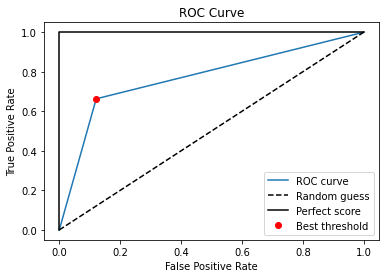

In [134]:

# call final_fun_2 for prediction
x_test_provider, test_auc, test_f1_score, cm, best_thresh= final_fun_2(X)

In [135]:
# print actual label along with predicted label
x_test_provider.head()

,Provider,PotentialFraud,predicted_label
0,PRV51005,1,1
1,PRV51008,0,0
2,PRV51011,0,0
3,PRV51012,0,0
4,PRV51016,0,0


In [136]:
x_test_provider.tail()

,Provider,PotentialFraud,predicted_label
1077,PRV57747,0,0
1078,PRV57748,0,0
1079,PRV57756,0,0
1080,PRV57758,0,0
1081,PRV57759,0,0
